# Setup

In [1]:
pip install pydub

In [2]:
from google.colab import drive

import os

import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

from tensorflow.keras import layers
import tensorflow as tf

import time

In [3]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Tim's Utility Functions

In [4]:

# Most of the Spectrograms and Inversion are taken from: https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start:stop]

    return out


def stft(
    X, fftsize=128, step=65, mean_normalize=True, real=False, compute_onesided=True
):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X


def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(
        stft(d, fftsize=fft_size, step=step_size, real=False, compute_onesided=True)
    )

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[
            specgram < -thresh
        ] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[
            specgram < thresh
        ] = thresh  # set anything less than the threshold as the threshold

    return specgram


# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(
    X_s, log=True, fft_size=512, step_size=512 / 4, n_iter=10
):

    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t


def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1e8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=True
            )
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=False
            )
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[: len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True, set_zero_phase=False)
    return np.real(X_t)


def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype("float64")
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print(
                    "WARNING: Large step size >50\% detected! "
                    "This code works best with high overlap - try "
                    "with 75% or greater"
                )
                offset_size = step
            offset = xcorr_offset(
                wave[wave_start : wave_start + offset_size],
                wave_est[est_start : est_start + offset_size],
            )
        else:
            offset = 0
        wave[wave_start:wave_end] += (
            win * wave_est[est_start - offset : est_end - offset]
        )
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1e-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype("float32"), x2[::-1].astype("float32"))
    corrs[:half] = -1e30
    corrs[-half:] = -1e30
    offset = corrs.argmax() - len(x1)
    return offset

# Parameters

In [5]:
### Parameters ###
fft_size = 2048  # window size for the FFT
step_size = fft_size // 16  # distance to slide along the window (in time)
spec_thresh = 4  # threshold for spectrograms (lower filters out more noise)
lowcut = 500  # Hz # Low cut for our butter bandpass filter
highcut = 15000  # Hz # High cut for our butter bandpass filter

In [6]:
PATH_PROJECT = '/content/drive/My Drive/Projects/Music GAN'

# Spectrogram

In [7]:
def get_spectrogram(wave_file_name):
  rate, data = wavfile.read(wave_file_name)
  data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
  # # Only use a short clip for our demo
  if np.shape(data)[0] / float(rate) > 10:
      data = data[0 : rate * 10]
  # print("Length in time (s): ", np.shape(data)[0] / float(rate))
  # Play the audio
  # IPython.display.Audio(data=data, rate=rate)

  return pretty_spectrogram(
      data.astype("float64"),
      fft_size=fft_size,
      step_size=step_size,
      log=True,
      thresh=spec_thresh,
    )


In [8]:
def visualize_spectrogram(wave_spectrogram):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
  cax = ax.matshow(
      np.transpose(wave_spectrogram),
      interpolation="nearest",
      aspect="auto",
      cmap=plt.cm.afmhot,
      origin="lower",
  )
  # fig.colorbar(cax)
  # plt.title("Original Spectrogram")
  # plt.savefig(PATH_PROJECT + '/testspectro.jpg')

# Test

In [9]:
# test_wave_file = PATH_PROJECT + '/wavs/01-dj_food-dark_river-sns.wav'
# test_spectrogram = get_spectrogram(test_wave_file)

In [10]:
# test_spectrogram.shape

# Main

In [11]:
all_spectrograms = []
for wav_file in os.listdir(PATH_PROJECT + '/wavs'):
  # get_spectrogram(wav_file)
  spectrogram = get_spectrogram(PATH_PROJECT + f'/wavs/{wav_file}')
  assert spectrogram.shape == (3440, 1024)
  all_spectrograms.append(spectrogram)

all_spectrograms = np.asarray(all_spectrograms)
print(all_spectrograms.shape)

(201, 3440, 1024)


In [12]:
# all_spectrograms_flat = []
# for wav_file in os.listdir(PATH_PROJECT + '/wavs'):
#   # get_spectrogram(wav_file)
#   print(wav_file)
#   spectrogram = get_spectrogram(PATH_PROJECT + f'/wavs/{wav_file}')
#   assert spectrogram.shape == (3440, 1024)
#   spectrogram_flat = spectrogram.reshape(3440*1024)
#   all_spectrograms_flat.append(spectrogram_flat)

# all_spectrograms_flat = np.asarray(all_spectrograms_flat)
# print(all_spectrograms_flat.shape)
# np.savetxt(PATH_PROJECT + "/spectrograms_flat.csv", all_spectrograms_flat, delimiter=",")

# Preprocess


In [13]:
BATCH_SIZE = 2

In [14]:
all_spectrograms = all_spectrograms.reshape(all_spectrograms.shape[0], 3440, 1024, 1)

In [15]:
print("Max ", np.max(all_spectrograms))
print("Min ", np.min(all_spectrograms))

Max  0.0
Min  -4.0


In [16]:
# Normalize inputs. Investigate why this is important
all_spectrograms = (all_spectrograms + 2)/2

In [17]:
all_spectrograms = tf.data.Dataset.from_tensor_slices(all_spectrograms).shuffle(201).batch(BATCH_SIZE)

# Generator

In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(860*256*16, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((860, 256, 16)))
    assert model.output_shape == (None, 860, 256, 16) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 860, 256, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 1720, 512, 4)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 3440, 1024, 1)

    return model

Use the (as yet untrained) generator to create an image.

In [19]:
generator = make_generator_model()

In [20]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# Discriminator

In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[3440, 1024, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [22]:
discriminator = make_discriminator_model()

In [23]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00021523]], shape=(1, 1), dtype=float32)


# Loss and optimizers

Define loss functions and optimizers for both models.


In [24]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training loop


In [28]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [29]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [30]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
  #   # Produce images for the GIF as we go
  #   display.clear_output(wait=True)
  #   generate_and_save_images(generator,
  #                            epoch + 1,
  #                            seed)

  #   # Save the model every 15 epochs
  #   if (epoch + 1) % 15 == 0:
  #     checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,
  #                          epochs,
  #                          seed)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [31]:
train(all_spectrograms, EPOCHS)

Time for epoch 1 is 62.40296292304993 sec
Time for epoch 2 is 61.757675886154175 sec
Time for epoch 3 is 59.521568298339844 sec
Time for epoch 4 is 59.48604679107666 sec
Time for epoch 5 is 59.45578575134277 sec
Time for epoch 6 is 59.41116786003113 sec
Time for epoch 7 is 59.4852991104126 sec
Time for epoch 8 is 59.44879722595215 sec
Time for epoch 9 is 59.587377309799194 sec
Time for epoch 10 is 59.485894441604614 sec
Time for epoch 11 is 59.517839431762695 sec
Time for epoch 12 is 59.480069398880005 sec
Time for epoch 13 is 59.50483202934265 sec
Time for epoch 14 is 59.508646726608276 sec
Time for epoch 15 is 59.552616357803345 sec
Time for epoch 16 is 59.477964639663696 sec
Time for epoch 17 is 59.48506140708923 sec
Time for epoch 18 is 59.44938826560974 sec
Time for epoch 19 is 59.51330256462097 sec
Time for epoch 20 is 59.45692825317383 sec
Time for epoch 21 is 59.48614144325256 sec
Time for epoch 22 is 59.42967939376831 sec
Time for epoch 23 is 59.452141523361206 sec
Time for ep

# Final test

In [35]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

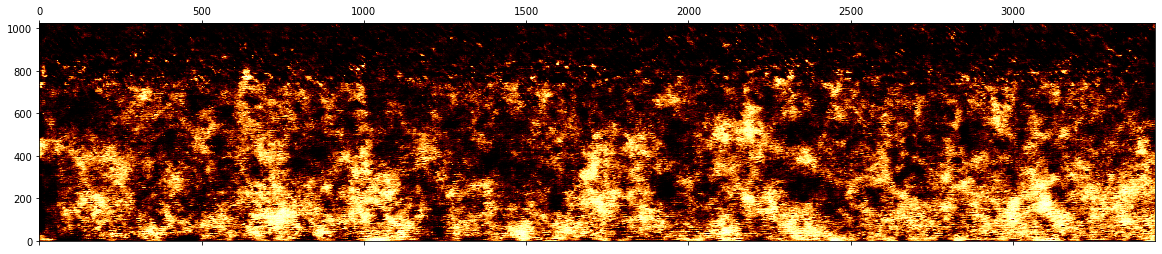

In [36]:
visualize_spectrogram(generated_image.numpy()[0,:,:,0])

In [37]:
recovered_audio_orig = invert_pretty_spectrogram(
    generated_image.numpy()[0,:,:,0], fft_size=fft_size, step_size=step_size, log=True, n_iter=10
)
IPython.display.Audio(data=recovered_audio_orig, rate=44100)